In [1]:
#importing libraries 
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#reading all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
#creating the vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
block_size = 3 #number of characters to be used to predict the next model

X, Y = [], []

for word in words:
    
    #print(word)
    
    context = [0] * block_size
    
    for ch in word + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [6]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

In [7]:
X.shape, X.dtype, Y.shape, Y.dtype
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
X.shape

torch.Size([228146, 3])

In [8]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [9]:
C = torch.randn((27, 2))
C

tensor([[-1.0503,  0.5231],
        [ 1.5129, -0.1112],
        [ 0.7379, -1.4513],
        [-0.5715, -0.1853],
        [-1.0886, -0.1241],
        [-2.3583,  1.5574],
        [ 0.1306, -0.6679],
        [-1.0257,  0.2588],
        [ 2.8154, -1.9607],
        [-0.7002, -0.7962],
        [-1.3409,  1.7029],
        [-0.2297,  1.1050],
        [-0.9409, -0.5661],
        [-1.9308,  0.1437],
        [-0.0412,  0.2724],
        [ 0.8665, -0.7463],
        [-0.0595, -1.2452],
        [ 0.5968, -1.0486],
        [-0.3338, -0.1661],
        [-0.5823, -0.8842],
        [-0.0650, -0.2748],
        [ 0.2950,  2.3221],
        [ 0.5270, -0.4078],
        [ 0.2100,  0.1487],
        [-0.3515,  0.1363],
        [-0.5596, -1.1875],
        [ 0.7994,  0.3044]])

In [10]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [11]:
#hidden layer
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [12]:
#converting the embedding from 32 * 3 * 2 ----> 32 * 6 for matrix multiplication
#torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

In [13]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([228146, 6])

In [14]:
torch.arange(18)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [15]:
emb.view(-1,6)

tensor([[-1.0503,  0.5231, -1.0503,  0.5231, -1.0503,  0.5231],
        [-1.0503,  0.5231, -1.0503,  0.5231, -2.3583,  1.5574],
        [-1.0503,  0.5231, -2.3583,  1.5574, -1.9308,  0.1437],
        ...,
        [ 0.7994,  0.3044,  0.7994,  0.3044, -0.5596, -1.1875],
        [ 0.7994,  0.3044, -0.5596, -1.1875,  0.7994,  0.3044],
        [-0.5596, -1.1875,  0.7994,  0.3044, -0.3515,  0.1363]])

In [16]:
#matrix multiplication and activation function of hidden layer
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h

tensor([[ 0.5391,  0.9985, -0.8528,  ..., -0.9309, -0.9994,  0.9964],
        [ 0.9990,  0.9993,  0.3197,  ..., -0.9490, -0.9998,  0.9993],
        [ 0.7891,  0.9997, -0.9752,  ..., -0.9981, -0.9998,  1.0000],
        ...,
        [ 0.9994, -0.5989,  0.9765,  ...,  0.2699,  1.0000,  0.9863],
        [ 0.8778,  0.4078,  0.5614,  ...,  0.9775, -0.2492,  0.7214],
        [-0.3341,  0.8792,  0.9977,  ...,  0.2561,  0.9887,  0.8748]])

In [17]:
h.shape

torch.Size([228146, 100])

In [18]:
#creating the final layer
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [19]:
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdims = True)

In [20]:
prob.shape

torch.Size([228146, 27])

In [21]:
prob[0].sum()

tensor(1.0000)

In [22]:
# now the full model

In [23]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 27), generator=g)
W1 = torch.randn((81, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [24]:
sum(p.nelement() for p in parameters) # number of parameters in total

22556

In [25]:
for parameter in parameters:
    parameter.requires_grad = True

In [26]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [27]:
lri = []
lossi = []
stepi = []

In [28]:
for i in range(200000):   
    
    
    #minibatch
    ix = torch.randint(0, Xtr.shape[0], (128,))
  
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 81) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())

    # backward pass
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    #learning rate optimisation
    #lr = lrs[i]
    
    lr = 0.1 
    # update
    for parameter in parameters:
        parameter.data += -lr * parameter.grad
        
    # track stats
    #lri.append(lr)
    stepi.append(i)
    lossi.append(loss.log10().item())


print(loss.item())

2.2176361083984375


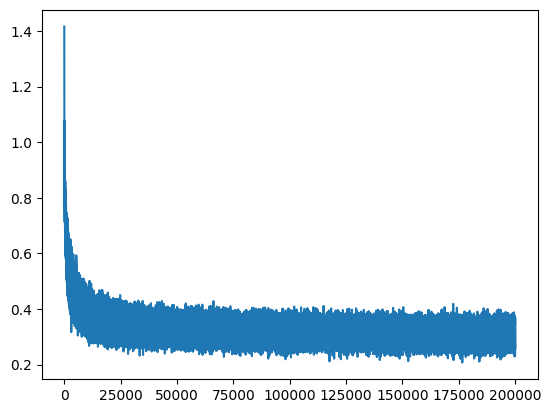

In [29]:
plt.plot(stepi, lossi)

In [30]:
emb = C[Xtr] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 81) @ W1 + b1) # (32, 200)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
print(loss.item())

2.0558807849884033


In [31]:
emb = C[Xdev] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 81) @ W1 + b1) # (32, 200)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.164302349090576


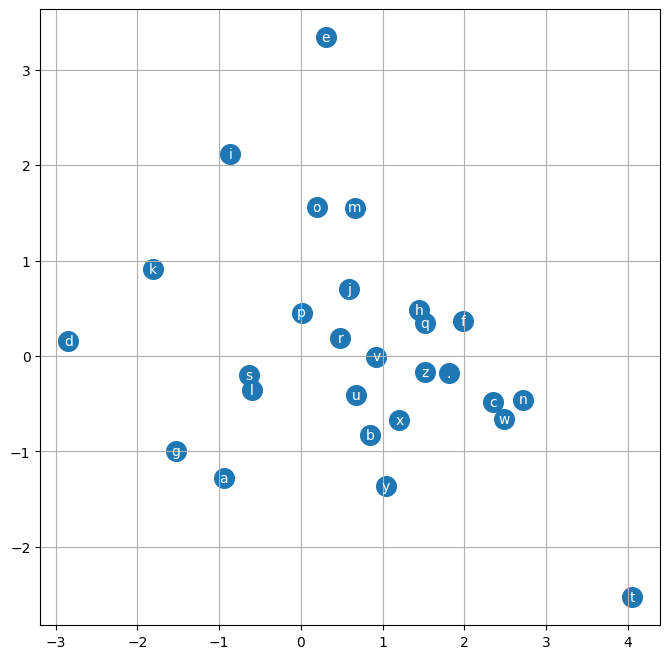

In [32]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [33]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mohani.
yazliee.
madhriah.
remmry.
ejerlee.
azelyn.
elii.
shyanelle.
elieananaraely.
kohlter.
noshubhrishiriel.
kendreelynn.
novalyn.
brence.
rhylene.
ehs.
kayshayanaha.
halina.
yarsuf.
zakelveulen.
